In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\Anthony\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### RNN Behaviors - Proof of concept

In this notebook, we will begin by defining a few functions that will be useful. After that, we will do some simple examples with random neural network as a proof of concept. After that, we will try with real data set.

Therefore, the plan is :
- Defining function to solve, plot, train and evaluate the quality of our neurons
- Examples with random matrix of different matrix
- Examples with real dataset
- Adding pVar

**Compute RNN**

In [2]:
def dydx(t,x,W, sigma, mu):
    '''Differential equation'''
    return -x + sigma(W @ x - mu)

def rnn(t, IC, dydx, W, sigma=lambda x: ((1+np.exp(-x))**(-1)), mu=0):
    '''Approximate RNN behaviors using RK4 numerical method
    -----------------------
    t : np.linspace()
        Time array
    IC : Line vector
        Initial condition
    dydx : Function
        Differential equation
    W : Matrix of shape (n_neuron x n_neuron)
        Weight matrix
    sigma : Function
        Activation function (sigmoid if unspecified)
    mu : float/int
        Activation threshold (0 if unspecified)
    ----------------------
    return result and dt
    '''
    n = len(IC)
    m = len(t)
    res = np.zeros((m, n))   #mxn matrix that contain our values
    res[0] = IC  # First line is redefine
    dt = (t[-1] - t[0])/m
    for i in range(1, m):
        k1 = dt * dydx(t[i-1], res[(i-1)], W=W, sigma=sigma, mu=mu)
        k2 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k1, W=W, sigma=sigma, mu=mu)
        k3 = dt * dydx(t[i-1] + 0.5 * dt, res[(i-1)] + 0.5 * k2, W=W, sigma=sigma, mu=mu)
        k4 = dt * dydx(t[i-1] + dt, res[(i-1)] + k3, W=W, sigma=sigma, mu=mu)
        res[i] = res[i-1] + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return res, dt

**Generate fake data for test**

In [3]:
def GenerateData(n_data, time, IC, W, ratio=0.6, mu=0, sigma=lambda x: (1+np.exp(-x))**(-1)):
    '''
    Generate fake data that follow a RNN function
    -------------------
    n_data : int
        Number of data per neuron
    time : float
        Time of our sample
    IC : Line 
        Initials conditions
    W : Square matrix with shape n_neurons x n_neurons
        Weight Matrix
    ratio : float or int ]0,1]
        Percentage of our fake data that will be use for training
    mu : float or int
        Activation threshold (0 if unspecified)
    sigma : function
        Non-linearities (sigmoid if unspecified)
    -------------------
    Return dict
    '''

    t = np.linspace(0, time, n_data)

    Slice = int(ratio * len(t))
    time_data = t[:Slice]
    Test_Data = np.array([])
    if ratio < 1:
        time_test = t[Slice:]
        Test_Data = rnn(t=time_test, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu).T

    Data, dt = rnn(t=time_data, IC=IC, dydx=dydx, W=W, sigma=sigma, mu=mu)
    Data = Data.T

    out = {}
    out["Data"] = Data
    out["Test_Data"] = Test_Data
    out["W"] = W
    out["dt"] = dt
    out["mu"] = mu

    return out

### Training

We use the following equation to represent our behavior :

$\dot{\vec{x}} = -x+\sigma(Wx+\mu)$

With Euler, we have :

$x(t+\Delta t) = x(t) + \Delta x =  x(t)[1-\Delta t]+\sigma(Wx-\mu)\Delta t$

*New features*:
- Code has been vectorize
- STD of the random matrix has been decrease
- Momentum was added

In [4]:
class RNNModel(nn.Module):

    def __init__(self, W, dt, mu):
        super(RNNModel, self).__init__()
        self.W = W
        self.dt = dt
        self.mu = mu
    
    def forward(self, x):
        return x * (1-self.dt) + (torch.sigmoid(torch.matmul(self.W, x) - self.mu))*self.dt

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from Hessianfree import HessianFree


def Train_RNN(n_neurons, x, dt, mu, lr=1, n_iters=500, g=0.001, momentum=0.9, verbose=False, loss_graph=False):
    '''
    Function that train our RNN to match a specific model
    ----------------------
    n_neurons : int
        Number of neurons in our RNN
    x : Matrix (n_data x n_neurons) np.array or torch.tensor
        Activity of neuron with their time step
    dt : float/int
        Delta_t (Euler's discretisation)
    mu : int/float
        Activity threshold (same for true data and predicted)
    lr : int/float
        learning rate(1 if unspecified)
    n_iters : int
        number of iteration (epochs) (500 if unspecified)
    verbose : bool
        Update on epochs (False if unspecified)
    loss_graph : bool
        Plot loss function
    ----------------------
    return dict
    '''
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    #W = torch.zeros(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = g * torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify
    
    model = RNNModel(W=W, dt=dt, mu=mu)
    #optimizer = HessianFree(model.parameters())
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss = nn.MSELoss()

    #x_pred = torch.zeros(x.shape[0], x.shape[1])

    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):
        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        #All of time step except the last one
        #With N time step, we never use x(t=N) 
        x_pred[1:] = x_pred_temp.T

        
        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #if 4*epoch < n_iters:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.8)
        #else:
        #    optimizer = torch.optim.SGD(model.parameters(), lr=4*lr, momentum=0.8)

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                with torch.no_grad():
                    y = x.detach().numpy()
                    y_pred = x_pred.detach().numpy()
                    pVar = 1 - ((np.linalg.norm(y-y_pred))**2/(np.linalg.norm(y_pred - np.mean(y_pred, axis=0)))**2)
                
                print(f"epoch {epoch}/{n_iters} loss {l:.6f} pVar {pVar:.3f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = lr
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"
    out["params"]["loss"] = f"{loss}"


    if loss_graph:
        t = np.linspace(0, n_iters, len(Total_loss))
        plt.plot(t, Total_loss, "r-")
        plt.grid(True)
        plt.title(f"Loss function with lr = {lr}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
    
    return out


**Adaptive learning rate**

In [11]:
def learn_rate(epoch, a, b):
    #format a*np.exp(b*epoch)
    return a * np.exp(b * epoch)

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def Train_RNN_AdaptLR(n_neurons, x, dt, mu, n_iters=500, verbose=False, loss_graph=False, a=0.01, b=0.0055, g=1, momentum=0.9):
    
    #Convert activity to tensor
    if not torch.is_tensor(x):
        x = torch.tensor(x, dtype=torch.float32)
    
    #Set up
    W = g*torch.randn(n_neurons, n_neurons, dtype=torch.float32, requires_grad=True)
    W = nn.Parameter(W)  #Parameter that will be modify

    Learning_rates = []
    Total_loss = []

    #Keeping our inital matrix for later
    with torch.no_grad():
        W0 = W.clone()

    #Training
    for epoch in range(n_iters):

        model = RNNModel(W=W, dt=dt, mu=mu)
        lr = learn_rate(epoch, a, b)
        Learning_rates.append(lr)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
        loss = nn.MSELoss()


        #Forward pass
        x_pred = torch.zeros(x.shape[0], x.shape[1])
        x_pred[0] = x[0]  #insert IC

        x_pred_temp = model(x[:-1].T)
        x_pred[1:] = x_pred_temp.T

        #Loss
        l = loss(x, x_pred)

        #Gradient
        l.backward()

        #update weight matrix
        optimizer.step()
        optimizer.zero_grad()

        if verbose:
            if (epoch+1) % 100 == 1:
                print(f"epoch {epoch}/{n_iters} loss {l:.6f}")

        with torch.no_grad():
            Total_loss.append(l.numpy())

    out = {}
    out["W"] = W.detach().numpy()
    out["W0"] = W0.detach().numpy()
    out["params"] = {}
    out["params"]["dt"] = dt
    out["params"]["lr"] = lr
    out["params"]["mu"] = mu
    out["params"]["lr"] = Learning_rates
    out["params"]["loss"] = Total_loss
    out["params"]["n_iters"] = n_iters
    out["params"]["optim"] = f"{optimizer}"


    if loss_graph:
        plt.plot(Learning_rates, Total_loss, "r-")
        plt.xlabel("learning rate (log)")
        plt.ylabel("loss")
        plt.xscale("log")
        plt.title(f"learning rate when working with {n_neurons} neurons")
        plt.show()
    
    return out


**Quality**

The following code allows us to identify the neurons that cause problem in our train model

In [7]:
def quality(n_neuron, true, train, num_max=1):
    '''
    Plot and identify the quality of the training
    ---------------------
    n_neuron : int
        Number of neurons in our system
    true : ndarray
        True value of our model
    train : ndarray
        Train model
    num_max : int
        Number of neurons with the worst loss function
    '''
    MSE_total = []

    for i in range(n_neuron):
        MSE = np.mean((train[:,i] - true[:,i])**2)
        MSE_total.append(MSE)

    plt.plot(np.linspace(1, n_neuron, n_neuron), MSE_total, "-")
    plt.xlabel("neuron")
    plt.ylabel("loss")
    plt.show()

    worst = []

    for i, neuron in enumerate((sorted(MSE_total)[::-1])):
        if i < num_max:
            worst.append(MSE_total.index(neuron))

    return worst


**Examples**
---------------

Let's begin with the same example as CURBD. We will take $172$ neurons and $4000$ time step. However, we will use $2500$ time step rather than $40$. We have:

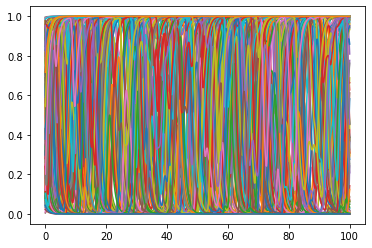

In [8]:
t = np.linspace(0, 100, 1000)
IC = np.random.rand(172)
W = 3*np.random.randn(172, 172)

data = GenerateData(n_data=4000, time=100, IC=IC, W=W , ratio=1)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/2500 loss 0.000144 pVar 0.997
epoch 100/2500 loss 0.000024 pVar 0.999
epoch 200/2500 loss 0.000019 pVar 1.000
epoch 300/2500 loss 0.000016 pVar 1.000
epoch 400/2500 loss 0.000014 pVar 1.000
epoch 500/2500 loss 0.000012 pVar 1.000
epoch 600/2500 loss 0.000011 pVar 1.000
epoch 700/2500 loss 0.000010 pVar 1.000
epoch 800/2500 loss 0.000010 pVar 1.000
epoch 900/2500 loss 0.000009 pVar 1.000
epoch 1000/2500 loss 0.000009 pVar 1.000
epoch 1100/2500 loss 0.000008 pVar 1.000
epoch 1200/2500 loss 0.000008 pVar 1.000
epoch 1300/2500 loss 0.000007 pVar 1.000
epoch 1400/2500 loss 0.000007 pVar 1.000
epoch 1500/2500 loss 0.000007 pVar 1.000
epoch 1600/2500 loss 0.000007 pVar 1.000
epoch 1700/2500 loss 0.000006 pVar 1.000
epoch 1800/2500 loss 0.000006 pVar 1.000
epoch 1900/2500 loss 0.000006 pVar 1.000
epoch 2000/2500 loss 0.000006 pVar 1.000
epoch 2100/2500 loss 0.000006 pVar 1.000
epoch 2200/2500 loss 0.000006 pVar 1.000
epoch 2300/2500 loss 0.000005 pVar 1.000
epoch 2400/2500 loss 0.00000

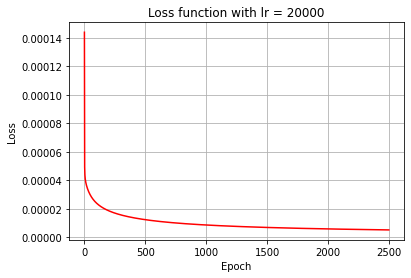

78.52056646347046


In [9]:
import time


start = time.time()
pred = Train_RNN(172, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, lr=20000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

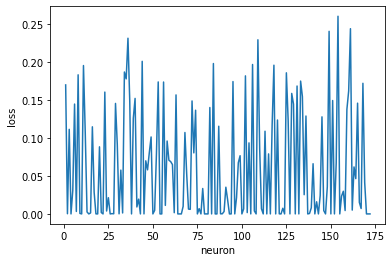

[153, 160]

In [10]:
t = np.linspace(0,150, 4000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(172, train=train, true=true, num_max=2)
qual

We can now plot our **worst** neuron's prediction to get an idea:

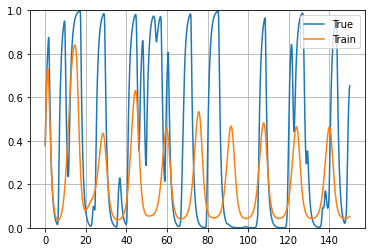

In [13]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,160], label="True")
plt.plot(t, train[:,160], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

Without surprise, our worst activity is a chaotic behavior. Also, we can see that the model is quite good between 0 and 100 which is the time in which we train the model. We can look at another example of more complex behavior. Remember that everything after 100 is a prediction.

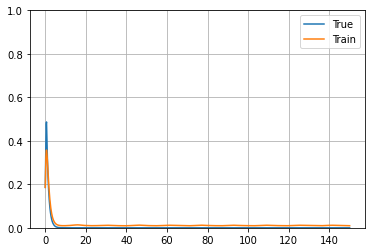

In [14]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,88], label="True")
plt.plot(t, train[:,88], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

Actually, most neurons are well model and look like that:

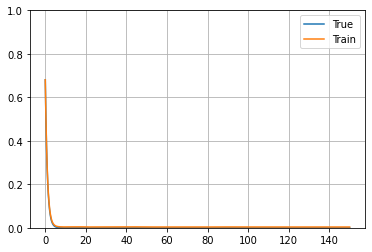

In [17]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,54], label="True")
plt.plot(t, train[:,54], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

---------------

Now, let's use $500$ neurons. We will have a chaotic behavior which is quite common with random matrix of this size. Chaotic matrix are hard to modelize because our model must have the exact same weight matrix to perfectly predict what's next

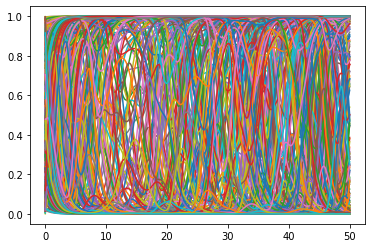

In [18]:
IC = np.random.rand(500)
W = np.random.randn(500, 500)
t = np.linspace(0, 50, 1000)

data = GenerateData(n_data=1500, IC=IC, time=50, W=W, ratio=1)

plt.plot(t, rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0])
plt.show()

epoch 0/2500 loss 0.000249 pVar 0.993
epoch 100/2500 loss 0.000016 pVar 1.000
epoch 200/2500 loss 0.000011 pVar 1.000
epoch 300/2500 loss 0.000008 pVar 1.000
epoch 400/2500 loss 0.000007 pVar 1.000
epoch 500/2500 loss 0.000006 pVar 1.000
epoch 600/2500 loss 0.000005 pVar 1.000
epoch 700/2500 loss 0.000004 pVar 1.000
epoch 800/2500 loss 0.000004 pVar 1.000
epoch 900/2500 loss 0.000004 pVar 1.000
epoch 1000/2500 loss 0.000003 pVar 1.000
epoch 1100/2500 loss 0.000003 pVar 1.000
epoch 1200/2500 loss 0.000003 pVar 1.000
epoch 1300/2500 loss 0.000003 pVar 1.000
epoch 1400/2500 loss 0.000003 pVar 1.000
epoch 1500/2500 loss 0.000002 pVar 1.000
epoch 1600/2500 loss 0.000002 pVar 1.000
epoch 1700/2500 loss 0.000002 pVar 1.000
epoch 1800/2500 loss 0.000002 pVar 1.000
epoch 1900/2500 loss 0.000002 pVar 1.000
epoch 2000/2500 loss 0.000002 pVar 1.000
epoch 2100/2500 loss 0.000002 pVar 1.000
epoch 2200/2500 loss 0.000002 pVar 1.000
epoch 2300/2500 loss 0.000002 pVar 1.000
epoch 2400/2500 loss 0.00000

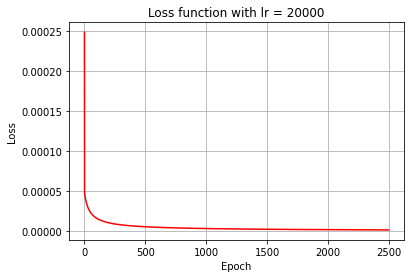

54.96118426322937


In [20]:
import time
start = time.time()
pred = Train_RNN(500, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, lr=20000, verbose=True, loss_graph=True, g=0.01)
end = time.time()
print(end-start)

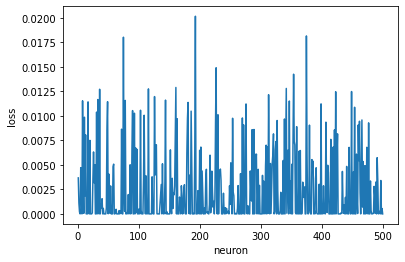

[192, 374, 74]

In [26]:
#Quality for t=100 (model train for t=50)
t = np.linspace(0, 50, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]
qual = quality(500, true=true, train=train, num_max=3)
qual

Here, we see that most neurons are well model except for a few. We can plot the **worst** one, which is the neuron #192

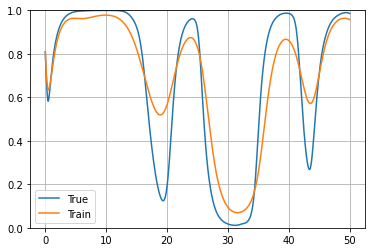

In [31]:
t = np.linspace(0,50, 1000)

plt.plot(t, true[:,192], label="True")
plt.plot(t, train[:,192], label="Train")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.show()

We can see that the model is not actually that far away from the reality. We have the same "shape" except with a difference in the moment where each shapes is encounter. We can see an example where the train though a neuron was oscillating when she had a chaotic behavior :

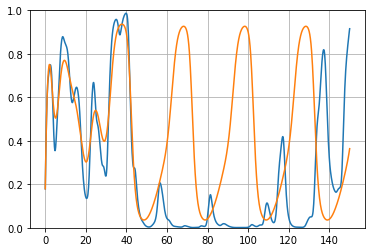

In [32]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,12], label="True")
plt.plot(t, train[:,12], label="Train")
plt.grid(True)
plt.ylim([0, 1])
plt.show()

As usual, most neuron converge to a certain value and they are well model:

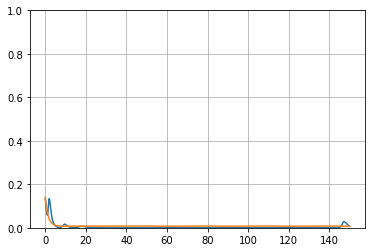

In [33]:
t = np.linspace(0,150, 1000)
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

plt.plot(t, true[:,322], label="True")
plt.plot(t, train[:,322], label="Train")
plt.grid(True)
plt.ylim([0, 1])
plt.show()

*Remark : the learning rate seems to depend on the number of data we have. If we have a high amount of data, we need a big learning rate and vice-versa. Here, with n_data=100. Here's an example*

In [34]:
IC = np.random.rand(40)
W = 10*np.random.randn(40, 40)

data = GenerateData(n_data=100, time=10, IC=IC, W=W, ratio=1)

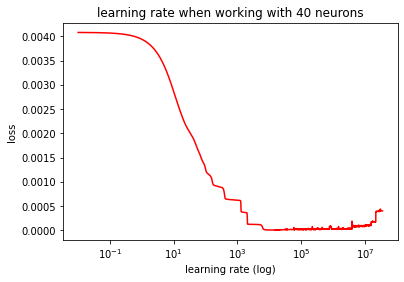

In [35]:
learn = Train_RNN_AdaptLR(40, data["Data"].T, data["dt"], data["mu"], n_iters=4000, loss_graph=True)

We see that $10^3$ is a great learning rate

epoch 0/4000 loss 0.002372 pVar 0.896
epoch 100/4000 loss 0.000046 pVar 0.998
epoch 200/4000 loss 0.000027 pVar 0.999
epoch 300/4000 loss 0.000021 pVar 0.999
epoch 400/4000 loss 0.000017 pVar 0.999
epoch 500/4000 loss 0.000015 pVar 0.999
epoch 600/4000 loss 0.000014 pVar 0.999
epoch 700/4000 loss 0.000013 pVar 1.000
epoch 800/4000 loss 0.000012 pVar 1.000
epoch 900/4000 loss 0.000011 pVar 1.000
epoch 1000/4000 loss 0.000010 pVar 1.000
epoch 1100/4000 loss 0.000010 pVar 1.000
epoch 1200/4000 loss 0.000009 pVar 1.000
epoch 1300/4000 loss 0.000009 pVar 1.000
epoch 1400/4000 loss 0.000009 pVar 1.000
epoch 1500/4000 loss 0.000008 pVar 1.000
epoch 1600/4000 loss 0.000008 pVar 1.000
epoch 1700/4000 loss 0.000008 pVar 1.000
epoch 1800/4000 loss 0.000008 pVar 1.000
epoch 1900/4000 loss 0.000007 pVar 1.000
epoch 2000/4000 loss 0.000007 pVar 1.000
epoch 2100/4000 loss 0.000007 pVar 1.000
epoch 2200/4000 loss 0.000007 pVar 1.000
epoch 2300/4000 loss 0.000007 pVar 1.000
epoch 2400/4000 loss 0.00000

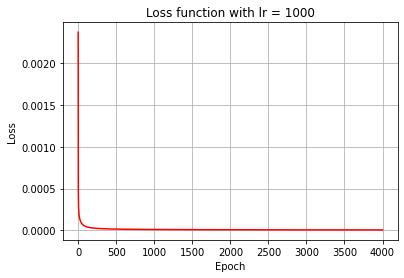

In [42]:
pred = Train_RNN(40, data["Data"].T, data["dt"], mu=data["mu"], lr=10**3, n_iters=4000, verbose=True, loss_graph=True, g=0.001)

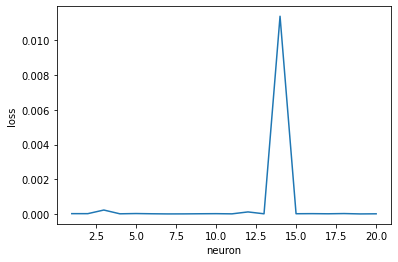

[13, 2, 11]

In [43]:
true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

t = np.linspace(0, 30, 1000)

qual = quality(20, true, train, num_max=3)
qual

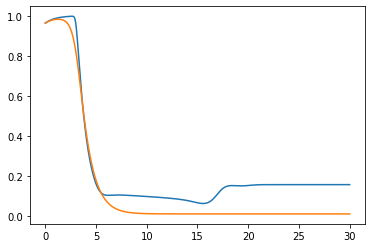

In [44]:
plt.plot(t, true[:,13])
plt.plot(t, train[:,13])
plt.show()

### Using real dataset

Let's use celegans_2019 with male_chemical. We can download the .csv and generate fake data with the matrix that was taken directly from the database. This dataset has 575 neurons. 

In [45]:
import pandas as pd
import numpy as np

data = pd.read_csv("celegans_male_chemical.csv")

W_true = np.zeros((575, 575))

for i in range(575):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index


In [46]:
IC = np.random.rand(575)

data = GenerateData(n_data=3000, time=30, IC=IC, W=W_true, ratio=1)

Let's find the best learning rate :

epoch 0/2500 loss 0.000029
epoch 100/2500 loss 0.000029
epoch 200/2500 loss 0.000029
epoch 300/2500 loss 0.000029
epoch 400/2500 loss 0.000029
epoch 500/2500 loss 0.000029
epoch 600/2500 loss 0.000029
epoch 700/2500 loss 0.000029
epoch 800/2500 loss 0.000028
epoch 900/2500 loss 0.000028
epoch 1000/2500 loss 0.000028
epoch 1100/2500 loss 0.000028
epoch 1200/2500 loss 0.000028
epoch 1300/2500 loss 0.000027
epoch 1400/2500 loss 0.000027
epoch 1500/2500 loss 0.000026
epoch 1600/2500 loss 0.000025
epoch 1700/2500 loss 0.000024
epoch 1800/2500 loss 0.000024
epoch 1900/2500 loss 0.000023
epoch 2000/2500 loss 0.000022
epoch 2100/2500 loss 0.000021
epoch 2200/2500 loss 0.000020
epoch 2300/2500 loss 0.000020
epoch 2400/2500 loss 0.000019


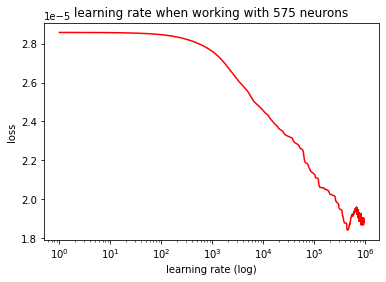

In [47]:
learn = Train_RNN_AdaptLR(575, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, loss_graph=True, verbose=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000007 pVar 0.997
epoch 100/1000 loss 0.000002 pVar 0.999
epoch 200/1000 loss 0.000001 pVar 0.999
epoch 300/1000 loss 0.000001 pVar 1.000
epoch 400/1000 loss 0.000001 pVar 1.000
epoch 500/1000 loss 0.000000 pVar 1.000
epoch 600/1000 loss 0.000000 pVar 1.000
epoch 700/1000 loss 0.000000 pVar 1.000
epoch 800/1000 loss 0.000000 pVar 1.000
epoch 900/1000 loss 0.000000 pVar 1.000


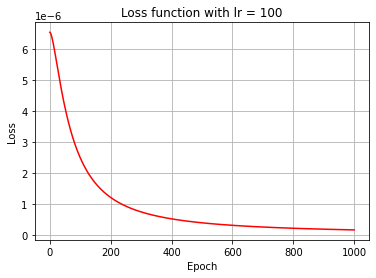

57.923553705215454


In [61]:
import time
start = time.time()
pred = Train_RNN(575, data["Data"].T, data["dt"], data["mu"], lr=10**2, n_iters=1000, verbose=True, loss_graph=True, g=0.001)
end = time.time()
print(end-start)

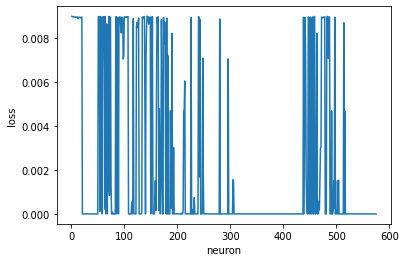

[142, 0, 458, 482, 54]

In [62]:
t = np.linspace(0,60,2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(575, true, train, 5)
qual

We can plot our *worst* neuron. The other neuron are really close to one another.

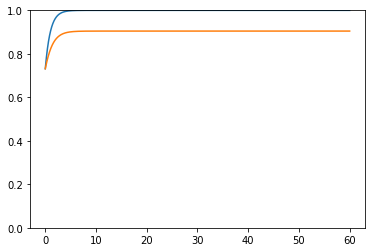

In [63]:
plt.plot(t, true[:,142])
plt.plot(t, train[:,142])
plt.ylim([0,1])
plt.show()

In fact, here's the complete model :

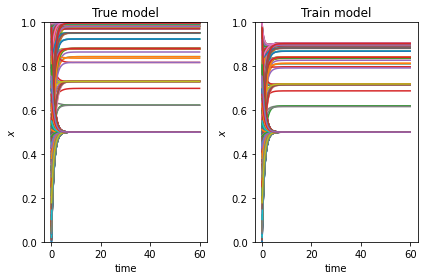

In [64]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

------------------
**Hermaphrodite chemical synapse**

In [65]:
import pandas as pd
import numpy as np

data = pd.read_csv("hermaphrodite_chemical_synapse.csv")

W_true = np.zeros((468, 468))

for i in range(468):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index

In [66]:
IC = np.random.rand(468)
data = GenerateData(n_data=2500, time=50, IC=IC, W=W_true, ratio=1)

epoch 0/2500 loss 0.000108
epoch 100/2500 loss 0.000108
epoch 200/2500 loss 0.000108
epoch 300/2500 loss 0.000108
epoch 400/2500 loss 0.000108
epoch 500/2500 loss 0.000108
epoch 600/2500 loss 0.000108
epoch 700/2500 loss 0.000107
epoch 800/2500 loss 0.000107
epoch 900/2500 loss 0.000106
epoch 1000/2500 loss 0.000105
epoch 1100/2500 loss 0.000104
epoch 1200/2500 loss 0.000102
epoch 1300/2500 loss 0.000100
epoch 1400/2500 loss 0.000099
epoch 1500/2500 loss 0.000097
epoch 1600/2500 loss 0.000093
epoch 1700/2500 loss 0.000090
epoch 1800/2500 loss 0.000087
epoch 1900/2500 loss 0.000084
epoch 2000/2500 loss 0.000081
epoch 2100/2500 loss 0.000078
epoch 2200/2500 loss 0.000085
epoch 2300/2500 loss 0.000088
epoch 2400/2500 loss 0.000096


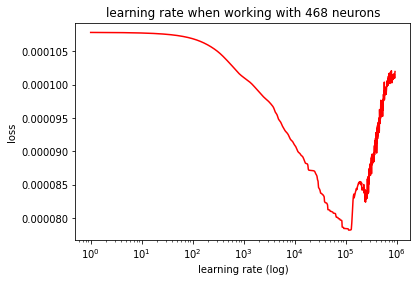

In [67]:
learn = Train_RNN_AdaptLR(468, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, verbose=True, loss_graph=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000019 pVar 0.985
epoch 100/1000 loss 0.000002 pVar 0.999
epoch 200/1000 loss 0.000001 pVar 0.999
epoch 300/1000 loss 0.000000 pVar 1.000
epoch 400/1000 loss 0.000000 pVar 1.000
epoch 500/1000 loss 0.000000 pVar 1.000
epoch 600/1000 loss 0.000000 pVar 1.000
epoch 700/1000 loss 0.000000 pVar 1.000
epoch 800/1000 loss 0.000000 pVar 1.000
epoch 900/1000 loss 0.000000 pVar 1.000


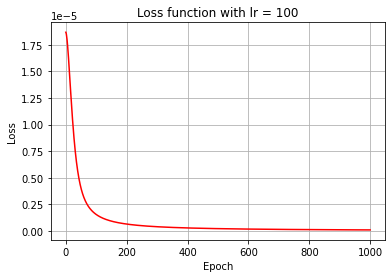

36.14523434638977


In [69]:
import time
start = time.time()
pred = Train_RNN(468, data["Data"].T, data["dt"], data["mu"], lr=10**2, n_iters=1000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

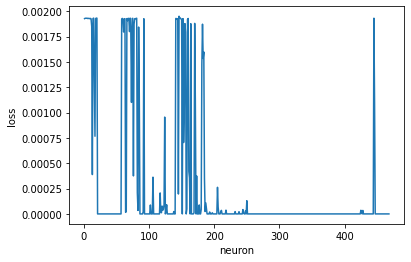

[145, 18, 147, 146, 14]

In [70]:
t = np.linspace(0,100,2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(468, true, train, 5)
qual

We can analyse our *worst* neuron :

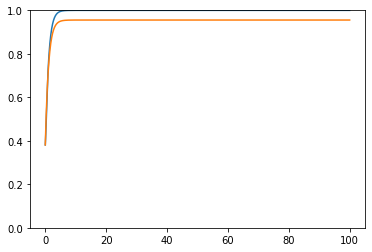

In [71]:
plt.plot(t, true[:,145])
plt.plot(t, train[:,145])
plt.ylim([0,1])
plt.show()

As usual, most of our neurons are almost perfect. We can plot our two models side by side to compare. We can see that a few neurons are a little bit off.

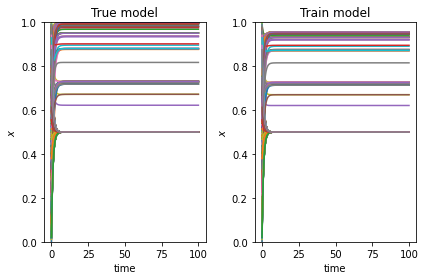

In [72]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

---------------------------
**Cintestinalis**

205 nodes

In [73]:
import pandas as pd
import numpy as np

data = pd.read_csv("celegansneural.csv")

W_true = np.zeros((205, 205))

for i in range(205):
    W_true[data.iloc[i,1],data.iloc[i,0]] = data.iloc[i,2]   #iloc -> index


In [74]:
IC = np.random.rand(205)

data = GenerateData(n_data=1500, time=30, IC=IC, W=W_true, ratio=1)

epoch 0/2500 loss 0.000090
epoch 100/2500 loss 0.000090
epoch 200/2500 loss 0.000090
epoch 300/2500 loss 0.000090
epoch 400/2500 loss 0.000090
epoch 500/2500 loss 0.000090
epoch 600/2500 loss 0.000089
epoch 700/2500 loss 0.000089
epoch 800/2500 loss 0.000089
epoch 900/2500 loss 0.000088
epoch 1000/2500 loss 0.000087
epoch 1100/2500 loss 0.000086
epoch 1200/2500 loss 0.000083
epoch 1300/2500 loss 0.000080
epoch 1400/2500 loss 0.000074
epoch 1500/2500 loss 0.000066
epoch 1600/2500 loss 0.000063
epoch 1700/2500 loss 0.000060
epoch 1800/2500 loss 0.000058
epoch 1900/2500 loss 0.000054
epoch 2000/2500 loss 0.000051
epoch 2100/2500 loss 0.000047
epoch 2200/2500 loss 0.000055
epoch 2300/2500 loss 0.000061
epoch 2400/2500 loss 0.000073


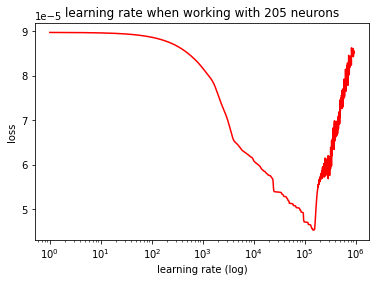

In [75]:
learn = Train_RNN_AdaptLR(205, data["Data"].T, data["dt"], mu=data["mu"], n_iters=2500, loss_graph=True, verbose=True, a=1, b=0.0055)

epoch 0/1000 loss 0.000008 pVar 0.996
epoch 100/1000 loss 0.000001 pVar 1.000
epoch 200/1000 loss 0.000000 pVar 1.000
epoch 300/1000 loss 0.000000 pVar 1.000
epoch 400/1000 loss 0.000000 pVar 1.000
epoch 500/1000 loss 0.000000 pVar 1.000
epoch 600/1000 loss 0.000000 pVar 1.000
epoch 700/1000 loss 0.000000 pVar 1.000
epoch 800/1000 loss 0.000000 pVar 1.000
epoch 900/1000 loss 0.000000 pVar 1.000


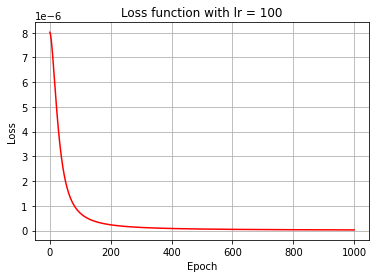

7.1026451587677


In [78]:
import time
start = time.time()
pred = Train_RNN(205, data["Data"].T, data["dt"], data["mu"], lr=10**2, n_iters=1000, verbose=True, loss_graph=True)
end = time.time()
print(end-start)

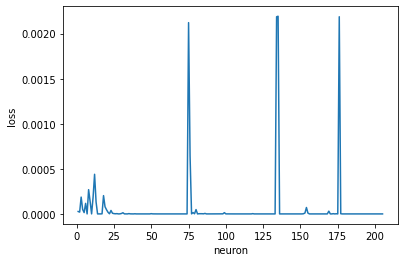

[134, 175, 133, 74, 75]

In [79]:
t = np.linspace(0, 60, 2000)

true = rnn(t=t, IC=IC, dydx=dydx, W=data["W"])[0]
train = rnn(t=t, IC=IC, dydx=dydx, W=pred["W"])[0]

qual = quality(205, true, train, 5)
qual

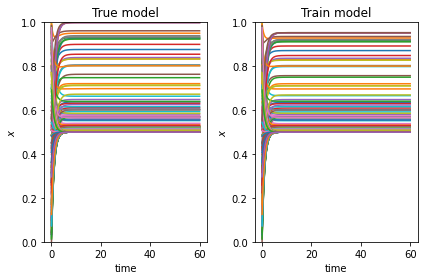

In [80]:
plt.figure(1)

plt.subplot(121)
plt.plot(t, true)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("True model")
plt.ylim([0,1])
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel("time")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.ylim([0,1])
plt.tight_layout()

plt.show()

As usual, we can look at our worst neuron

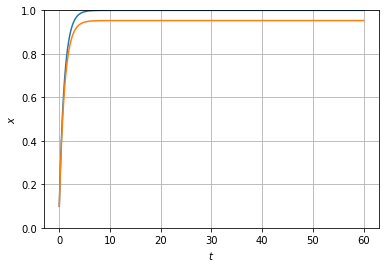

In [81]:
plt.plot(t, true[:,134], label="True")
plt.plot(t, train[:,134], label="Train")
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.ylim([0,1])
plt.grid(True)
plt.show()

--------------------

**CURBD**

We will use the exact same condition as used in *exampleFiringRateModelFitting* by P.Desrosiers. We will then compare the pVar of our training sample to measure the quality of our model. Let's begin by loading our model:

In [8]:
import numpy as np
import pylab
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

ts = np.load('1541_F_dff.npy')
ts = ts[:,0:4000]
print(len(ts))
# Smoothing and z-scoring 
sigma = 60
(N,T) = ts.shape
filtered_ts = np.zeros((N,T))
for i in range(N):
    new_ts = zscore(ts[i,:])
    #new_ts = new_ts-np.min(new_ts)
    new_ts = new_ts/np.max(np.abs(new_ts))
    new_ts = gaussian_filter1d(new_ts, sigma)
    filtered_ts[i,:]= new_ts


172


We have 172 neurons with 4000 time steps. We will train a matrix on those time step. However, those time step can have negative value since CURBD use a $\tanh$ model while we use a sigmoid. We will transform the data to put it between 0 and 1. We begin by doing an offset so the smallest value goes to 0. Then, we divide by the biggest value to have a series of data between 0 and 1:

In [9]:
#(filtered_ts.T[:,1]) gives the 4000 time steps for the neuron #1

mini = np.min(filtered_ts)

filtered_ts += abs(mini)

filtered_ts /= np.max(filtered_ts)

print(np.min(filtered_ts))
print(np.max(filtered_ts))

0.0
1.0


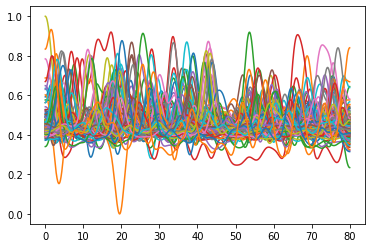

In [12]:
t = np.linspace(0, 80, 4000)
plt.plot(t, filtered_ts.T[:])
plt.show()

We begin by evaluating the optimal learning rate. We will use a $dt=0.02$ just like the example. The total time with 4000 time steps is therefore 80sec.

epoch 0/2500 loss 0.000081
epoch 100/2500 loss 0.000081
epoch 200/2500 loss 0.000081
epoch 300/2500 loss 0.000081
epoch 400/2500 loss 0.000081
epoch 500/2500 loss 0.000081
epoch 600/2500 loss 0.000081
epoch 700/2500 loss 0.000081
epoch 800/2500 loss 0.000081
epoch 900/2500 loss 0.000081
epoch 1000/2500 loss 0.000080
epoch 1100/2500 loss 0.000079
epoch 1200/2500 loss 0.000077
epoch 1300/2500 loss 0.000075
epoch 1400/2500 loss 0.000072
epoch 1500/2500 loss 0.000068
epoch 1600/2500 loss 0.000065
epoch 1700/2500 loss 0.000061
epoch 1800/2500 loss 0.000056
epoch 1900/2500 loss 0.000053
epoch 2000/2500 loss 0.000050
epoch 2100/2500 loss 0.000047
epoch 2200/2500 loss 0.000042
epoch 2300/2500 loss 0.000036
epoch 2400/2500 loss 0.000053


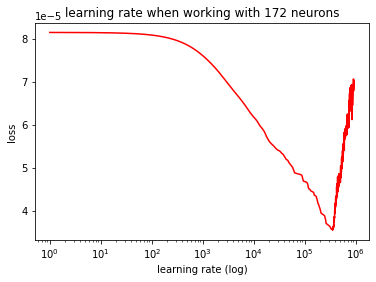

In [29]:
learn = Train_RNN_AdaptLR(172, filtered_ts.T, dt=0.02, mu=0, n_iters=2500, verbose=True, loss_graph=True, a=1, b=0.0055, g=1.3)

epoch 0/2500 loss 0.000074 pVar 0.979
epoch 100/2500 loss 0.000033 pVar 0.991
epoch 200/2500 loss 0.000028 pVar 0.992
epoch 300/2500 loss 0.000025 pVar 0.993
epoch 400/2500 loss 0.000021 pVar 0.994
epoch 500/2500 loss 0.000020 pVar 0.994
epoch 600/2500 loss 0.000019 pVar 0.995
epoch 700/2500 loss 0.000017 pVar 0.995
epoch 800/2500 loss 0.000016 pVar 0.995
epoch 900/2500 loss 0.000016 pVar 0.996
epoch 1000/2500 loss 0.000015 pVar 0.996
epoch 1100/2500 loss 0.000014 pVar 0.996
epoch 1200/2500 loss 0.000014 pVar 0.996
epoch 1300/2500 loss 0.000013 pVar 0.996
epoch 1400/2500 loss 0.000012 pVar 0.997
epoch 1500/2500 loss 0.000012 pVar 0.997
epoch 1600/2500 loss 0.000012 pVar 0.997
epoch 1700/2500 loss 0.000012 pVar 0.997
epoch 1800/2500 loss 0.000011 pVar 0.997
epoch 1900/2500 loss 0.000011 pVar 0.997
epoch 2000/2500 loss 0.000010 pVar 0.997
epoch 2100/2500 loss 0.000010 pVar 0.997
epoch 2200/2500 loss 0.000009 pVar 0.997
epoch 2300/2500 loss 0.000009 pVar 0.997
epoch 2400/2500 loss 0.00000

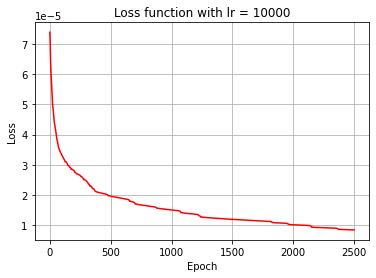

42.26724720001221


In [42]:
import time
start=time.time()
pred = Train_RNN(172, filtered_ts.T, 0.02, mu=0.6, lr=10**4, n_iters=2500, verbose=True, loss_graph=True, g=1, momentum=0.9)
end = time.time()
print(end-start)

In [43]:
t = np.linspace(0,80,4000)
train = rnn(t, IC=filtered_ts.T[0], dydx=dydx, W=pred["W"])[0]

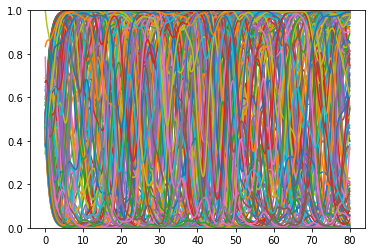

In [44]:
plt.plot(t, train[:])
#plt.plot(t, filtered_ts.T[:])
plt.ylim([0,1])
plt.show()

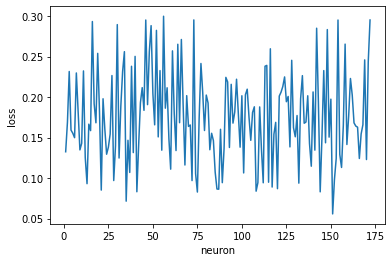

[55, 72, 171, 45, 153]

In [45]:
t = np.linspace(0, 80, 4000)
true = filtered_ts.T
train = rnn(t=t, IC=filtered_ts.T[0], dydx=dydx, W=pred["W"])[0]

qual = quality(172, true, train, 5)
qual

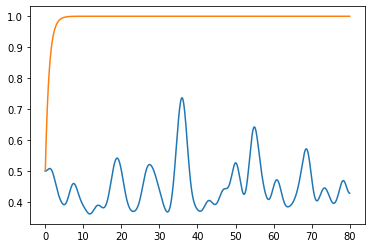

In [47]:
plt.plot(t, true[:,55], label="True")
plt.plot(t, train[:,55], label="Train")
plt.show()

-----------------

In [52]:
import time
from CURBD import trainMultiRegionRNN

t_init = time.time()

regions = []
regions.append(['Region A', np.arange(0, N)])
regions = np.array(regions, dtype=object)

model = trainMultiRegionRNN(filtered_ts,
                                  g=1.3,
                                  dtData=0.02,
                                  dtFactor=5,
                                  regions=regions,
                                  tauRNN=0.1,
                                  nRunTrain=40,
                                  verbose=True,
                                  nRunFree=5,
                                 plotStatus=False)

print(time.time()-t_init)

trial=0 pVar=0.363593 chi2=9.175075
trial=1 pVar=0.227998 chi2=11.181474
trial=2 pVar=0.309791 chi2=10.012282
trial=3 pVar=0.393750 chi2=8.785283
trial=4 pVar=0.498130 chi2=7.261213
trial=5 pVar=0.535157 chi2=6.728811
trial=6 pVar=0.596837 chi2=5.834378
trial=7 pVar=0.635085 chi2=5.278798
trial=8 pVar=0.672088 chi2=4.747527
trial=9 pVar=0.692199 chi2=4.456400
trial=10 pVar=0.707878 chi2=4.228537
trial=11 pVar=0.724851 chi2=3.978030
trial=12 pVar=0.731097 chi2=3.886264
trial=13 pVar=0.738679 chi2=3.783812
trial=14 pVar=0.761860 chi2=3.448860
trial=15 pVar=0.774392 chi2=3.261227
trial=16 pVar=0.798917 chi2=2.905548
trial=17 pVar=0.794497 chi2=2.972909
trial=18 pVar=0.795625 chi2=2.953496
trial=19 pVar=0.803191 chi2=2.850488
trial=20 pVar=0.820372 chi2=2.600096
trial=21 pVar=0.822670 chi2=2.564340
trial=22 pVar=0.830026 chi2=2.453686
trial=23 pVar=0.822387 chi2=2.563947
trial=24 pVar=0.822117 chi2=2.568838
trial=25 pVar=0.822775 chi2=2.560963
trial=26 pVar=0.827653 chi2=2.491908
trial=27 

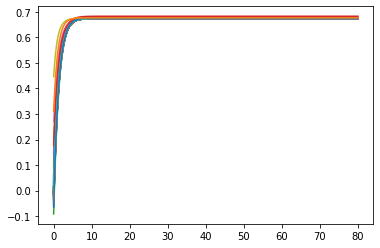

In [59]:
W_true = model["J"]

t = np.linspace(0, 80, 4000)

curbd = rnn(t=t, IC=filtered_ts.T[0], dydx=dydx, W=W_true)[0]

plt.plot(t, curbd)
plt.show()

--------------------

In [58]:
import numpy as np
import pylab
from numpy.linalg import svd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

ts = np.load('1541_F_dff.npy')
ts = ts[:,0:4000]
print(len(ts))
# Smoothing and z-scoring 
sigma = 60
(N,T) = ts.shape
filtered_ts = np.zeros((N,T))
for i in range(N):
    new_ts = zscore(ts[i,:])
    #new_ts = new_ts-np.min(new_ts)
    new_ts = new_ts/np.max(np.abs(new_ts))
    new_ts = gaussian_filter1d(new_ts, sigma)
    filtered_ts[i,:]= new_ts

172


In [60]:
import time
from CURBD import trainMultiRegionRNN

t_init = time.time()

regions = []
regions.append(['Region A', np.arange(0, N)])
regions = np.array(regions, dtype=object)

model = trainMultiRegionRNN(filtered_ts,
                                  g=1.3,
                                  dtData=0.02,
                                  dtFactor=5,
                                  regions=regions,
                                  tauRNN=0.1,
                                  nRunTrain=40,
                                  verbose=True,
                                  nRunFree=5,
                                 plotStatus=False)

print(time.time()-t_init)

trial=0 pVar=0.596091 chi2=19.503830
trial=1 pVar=0.339463 chi2=31.958616
trial=2 pVar=0.464287 chi2=25.920697
trial=3 pVar=0.564231 chi2=21.093785
trial=4 pVar=0.661790 chi2=16.342220
trial=5 pVar=0.736228 chi2=12.730444
trial=6 pVar=0.793529 chi2=9.983322
trial=7 pVar=0.825260 chi2=8.442480
trial=8 pVar=0.858457 chi2=6.837513
trial=9 pVar=0.883305 chi2=5.638540
trial=10 pVar=0.897452 chi2=4.950865
trial=11 pVar=0.908524 chi2=4.418897
trial=12 pVar=0.918765 chi2=3.918299
trial=13 pVar=0.924576 chi2=3.633045
trial=14 pVar=0.931127 chi2=3.312521
trial=15 pVar=0.935710 chi2=3.093036
trial=16 pVar=0.939325 chi2=2.917511
trial=17 pVar=0.942967 chi2=2.743284
trial=18 pVar=0.945868 chi2=2.605005
trial=19 pVar=0.947963 chi2=2.505504
trial=20 pVar=0.949429 chi2=2.435643
trial=21 pVar=0.951301 chi2=2.346191
trial=22 pVar=0.952330 chi2=2.295040
trial=23 pVar=0.953372 chi2=2.244218
trial=24 pVar=0.953860 chi2=2.220210
trial=25 pVar=0.954580 chi2=2.183672
trial=26 pVar=0.955484 chi2=2.138815
trial

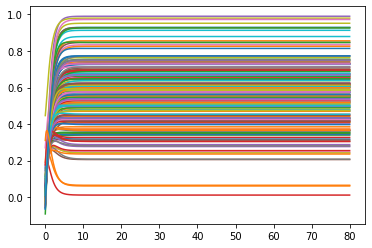

In [61]:
W_true = model["J"]

t = np.linspace(0, 80, 4000)

curbd = rnn(t=t, IC=filtered_ts.T[0], dydx=dydx, W=W_true)[0]

plt.plot(t, curbd)
plt.show()

epoch 0/500 loss 0.000014 pVar 0.994
epoch 100/500 loss 0.000001 pVar 1.000
epoch 200/500 loss 0.000000 pVar 1.000
epoch 300/500 loss 0.000000 pVar 1.000
epoch 400/500 loss 0.000000 pVar 1.000


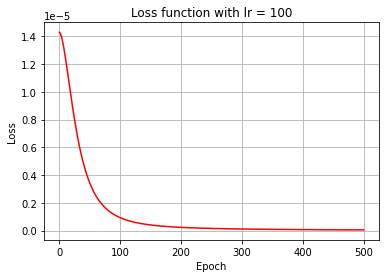

In [68]:
pred = Train_RNN(172, curbd, 0.02, mu=0, lr=10**2, n_iters=500, verbose=True, loss_graph=True, g=0.01, momentum=0.9)

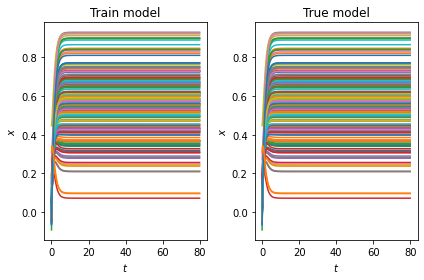

In [70]:
train = rnn(t=t, IC=curbd[0], dydx=dydx, W=pred["W"])[0]

plt.figure(1)
plt.subplot(121)
plt.plot(t, train)
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.title("Train model")
plt.tight_layout()

plt.subplot(122)
plt.plot(t, train)
plt.xlabel(r"$t$")
plt.ylabel(r"$x$")
plt.title("True model")
plt.tight_layout()
plt.show()